# Export RS image

In [23]:
#https://anaconda.org/epihua/scatter_test-copy1/notebook
from IPython.display import Image, display, HTML

%matplotlib inline

from pylab import *
import datetime

import ee
ee.Initialize()

## 1. Display Landsat 

### 1.1 Display Landsat Image

In [24]:
region = ee.Geometry.Rectangle([-122.5, 35.0, -122.4, 35.1]);
raw = ee.Image('LANDSAT/LC8_L1T_TOA/LC80440342014077LGN00');
print(raw.getThumbUrl())

https://earthengine.googleapis.com//api/thumb?thumbid=b946f22f80f877a21798f2282a8da1de&token=60b02228811eabb420fc8ea1c7947228


In [25]:
Image(url=raw.getThumbUrl())

###     1.2  from ImageCollection

In [43]:
regionfilter = ee.Geometry.Rectangle([135.4, 34.9, 135.5, 35.0])
CL = ee.ImageCollection('LANDSAT/LC8_SR')
 
##filter Date and Region
CL201601 = CL.filterDate('2016-01-01', '2016-02-02').filterBounds(regionfilter.toGeoJSON())

In [45]:
info_prop = CL201601.toList(100).getInfo()[0]['properties']

#print(info_prop)
print('PATH:', info_prop['wrs_path'])
print('ROW:', info_prop['wrs_row'])


info_bands = CL201601.toList(100).getInfo()[0]['bands']

#print(info_bands)
print('Dimensions:', info_bands[0]['dimensions'])
print('Number of bands:', len(info_bands))

##see bands
for ids in range(0,len(info_bands),1):
    print(info_bands[ids]['id'])

('PATH:', 110)
('ROW:', 36)
('Dimensions:', [7691, 7831])
('Number of bands:', 9)
B1
B2
B3
B4
B5
B6
B7
cfmask
cfmask_conf


ImageCollection to image

In [47]:
##pick up the first one
IM = ee.Image(CL201601.first())

##information of selected image through python
props = IM.getInfo()['properties']
#print(props)
path = props['wrs_path']
row = props['wrs_row']
date = props['system:time_start']

system_time = datetime.datetime.fromtimestamp((date / 1000) - 3600) 
date_str = system_time.strftime("%Y-%m-%d @ %H:%M")

print('PRPDUCT ID:',props['system:index'])
print('DATE:',date_str)
print('PATH:', path)
print('ROW:', row)

('PRPDUCT ID:', u'LC81100362016002')
('DATE:', '2016-01-02 @ 09:34')
('PATH:', 110)
('ROW:', 36)


In [48]:
##calculate ndvi
ndvi = (IM.select('B5').subtract(IM.select('B4'))).divide(IM.select('B5').add(IM.select('B4')));
print(ndvi.getThumbUrl())

https://earthengine.googleapis.com//api/thumb?thumbid=3d6af91303acb11812361a021637ee7f&token=e7f5199adcb219354899475d7408e1b1


In [49]:
#Image(url=ndvi.getThumbUrl({'region':region.toGeoJSON()}))
ndvi_palette = 'FFFFFF, CE7E45, DF923D, F1B555, FCD163, 99B718, 74A901, 66A000, 529400, 3E8601, 207401, 056201, 004C00, 023B01, 012E01, 011D01, 011301'
vizParams = {'min': -0.1, 'max': 1, 'palette': ndvi_palette}
Image(url=ndvi.getThumbUrl(vizParams))


define a parameter as list

https://developers.google.com/earth-engine/exporting

maxPixels

The maxPixels parameter is intended to prevent very large exports from inadvertently being created. Increase maxPixels if the default value is too low for your intended output image. If the output image file is large, it will be exported as multiple tiles. If the image is split into tiles, the filename of each tile will be in the form baseFilename-yMin-xMin where xMin and yMin are the coordinates of each tile within the overall bounding box of the exported image.

In [32]:
IM_list = IM.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=regionfilter,
  maxPixels=5e9);

pick up band values

In [33]:
raw4 = ee.Array(IM_list.get('B4'))
band4 = array(raw4.getInfo())
print(size(band4))

raw5 = ee.Array(IM_list.get('B5'))
band5 = array(raw5.getInfo())
print(size(band5))


112515
112515


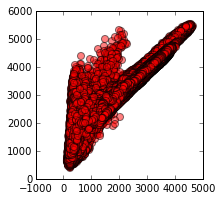

In [34]:
fig1 = figure(figsize=(3,3), dpi=80)
scatter(band4, band5, s=50, c='red', alpha=0.5)


# 2. Export 

## 2.1 Export to Google Drive

### 2.1.1 original data

#### Compare with original data downloaded from Earth Explorer

In [340]:
#.float() is needed
## check again
## 25 tif files were created...

#raw_float = raw_image.float()
IM_int = IM.int16()

task = ee.batch.Export.image(IM_int, 'test_img', {
        'maxPixels':5e9})
task.start()


In [341]:
task.status()

{u'creation_timestamp_ms': 1479971126284,
 u'description': u'test_img',
 u'id': u'BPWOHWMFCZ6UTPQYKNHBNZZC',
 u'state': u'READY',
 u'task_type': u'EXPORT_IMAGE',
 u'update_timestamp_ms': 1479971126284}

In [342]:
import time 
while task.status()['state'] == 'RUNNING':
    print 'Running...'
    time.sleep(100)
print 'Done.', task.status()

Running...
Running...
Running...
Done. {u'task_type': u'EXPORT_IMAGE', u'description': u'test_img', u'output_url': [u'https://drive.google.com/'], u'update_timestamp_ms': 1479971402160, u'creation_timestamp_ms': 1479971126284, u'state': u'COMPLETED', u'start_timestamp_ms': 1479971129715, u'id': u'BPWOHWMFCZ6UTPQYKNHBNZZC'}


### 2.1.2 NDVI data

In [347]:
ndvi_int = ndvi.multiply(10000).int8()

In [ ]:
task = ee.batch.Export.image(ndvi_int, 'ndvi_img', {
        'maxPixels':5e9})
task.start()

In [348]:
time.sleep(10)
while task.status()['state'] == 'RUNNING':
    print 'Running...'
    time.sleep(100)
print 'Done.', task.status()

Running...
Done. {u'task_type': u'EXPORT_IMAGE', u'description': u'ndvi_img', u'output_url': [u'https://drive.google.com/'], u'update_timestamp_ms': 1479973407520, u'creation_timestamp_ms': 1479973357454, u'state': u'COMPLETED', u'start_timestamp_ms': 1479973367118, u'id': u'5QKMVQGBIFUOJHILKQA46YS6'}


In [345]:
##see also this code
#https://13975973057543748996.googlegroups.com/attach/2a8c2ddcad1333ad/batch_clip_MODIS-saveAsImages.py?part=0.1&view=1&vt=ANaJVrHr1ij01pneYdSXzJ693-37mvKmyMznjf3vzaT6BTc6DJAScLapG94FU3OrpqxF0WGiBumViTiDdBvlOBfVfzlKNCnF8dL0IWGY9LcY_O3z6T4uoGc


## 2.2 Download to local

see http://qiita.com/mski_iksm/items/bfb04adbf9a403e5410d

In [40]:
import urllib2

def downloadZip(url):
    u = urllib2.urlopen(url)

    meta = u.info()

    # A zip download
    file_name = (meta.getheaders("Content-disposition")[0]).replace('attachment; filename=', '')
    f = open(file_name, 'wb')
    print "Downloading: %s " % (file_name)
    #os.system('cls')
    file_size_dl = 0
    block_sz = 8192
    while True:
        buffer = u.read(block_sz)
        if not buffer:
            break

        file_size_dl += len(buffer)
        f.write(buffer)
        status = r"%10d  " % (file_size_dl)
        status = status + chr(8)*(len(status)+1)
        print status,

    f.close()
    return

In [41]:
url=ndvi.getDownloadURL(vizParams)
print(url)
downloadZip(url)

https://earthengine.googleapis.com//api/download?docid=d7fbe552387982377adafc5bd0e2dff7&token=79e5c00159e3eb48e456c3b2eb926175
Downloading: d7fbe552387982377adafc5bd0e2dff7.zip 
      8192        16384        24576        32768        40960        49152        57344        65536        73728        81920        90112        98304       106496       114688       122880       131072       139264       147456       155648       163840       172032       180224       188416       196608       204800       212992       221184       229376       237568       245760       253952       262144  